In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the datasets
transactions_df = pd.read_csv('../data/updated_fraud_transactions.csv')
customers_df = pd.read_csv('../data/customer_dataset 1.csv')

# Display the first few rows of each dataset
print(transactions_df.head())
print(customers_df.head())

  Transaction ID            Timestamp  Sender Account ID Transaction Type  \
0         T00001  2023-08-14 08:37:07              10095         Transfer   
1         T00002  2023-12-04 12:54:11              10098         Transfer   
2         T00003  2023-07-09 23:16:11              10097           Credit   
3         T00004  2023-06-26 07:04:39              10039           Credit   
4         T00005  2023-09-28 02:40:56              10018            Debit   

  IN_OUT   Amount Recipient Bank  Fraud  
0     In  4887.67          B0004      0  
1     In  2371.33         B00010      0  
2     In  4733.44          B0008      0  
3     In  1544.12          B0005      0  
4    Out  3978.04          B0004      0  
   Customer ID                Name  Age      Location  Gender Account Type  \
0        10001      Nimal Fernando   61        Jaffna  Female      Savings   
1        10002  Sunil Samarasinghe   60        Jaffna   Other      Current   
2        10003    Ruwan Jayasinghe   67         Gal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Transaction ID     100000 non-null  object 
 1   Timestamp          100000 non-null  object 
 2   Sender Account ID  100000 non-null  int64  
 3   Transaction Type   100000 non-null  object 
 4   IN_OUT             100000 non-null  object 
 5   Amount             100000 non-null  float64
 6   Recipient Bank     100000 non-null  object 
 7   Fraud              100000 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 6.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Customer ID   100 non-null    int64 
 1   Name          100 non-null    object
 2   Age           100 non-null    int64 
 3   Location      10

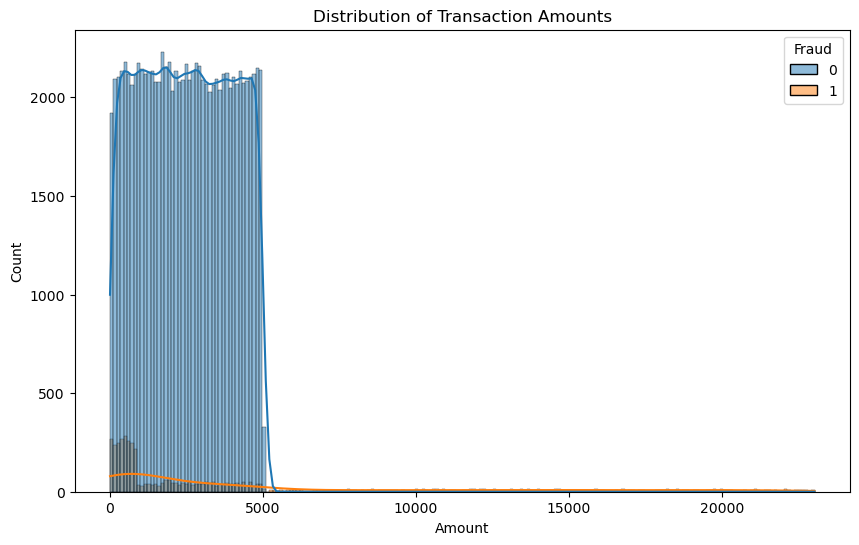

ValueError: could not convert string to float: 'T00001'

In [6]:
# Basic exploration
print(transactions_df.info())
print(customers_df.info())

# Check class distribution
print(transactions_df['Fraud'].value_counts(normalize=True))

# Visualize transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(data=transactions_df, x='Amount', hue='Fraud', kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()

# Correlation matrix
correlation_matrix = transactions_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Transaction Features')
plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify numerical and categorical columns
numerical_features = ['Amount', 'Age', 'Device Count']
categorical_features = ['Transaction Type', 'IN_OUT', 'Recipient Bank', 'Gender', 'Account Type', 'Location']

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Merge datasets
merged_df = pd.merge(transactions_df, customers_df, left_on='Sender Account ID', right_on='Customer ID')

# Prepare feature matrix and target variable
X = merged_df.drop(['Fraud', 'Transaction ID', 'Timestamp', 'Customer ID', 'Name'], axis=1)
y = merged_df['Fraud']

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

In [8]:
# Time-based features
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])
merged_df['Hour'] = merged_df['Timestamp'].dt.hour
merged_df['DayOfWeek'] = merged_df['Timestamp'].dt.dayofweek

# Aggregate features
avg_amount_per_customer = merged_df.groupby('Sender Account ID')['Amount'].mean().reset_index()
avg_amount_per_customer.columns = ['Sender Account ID', 'AvgAmountPerCustomer']
merged_df = pd.merge(merged_df, avg_amount_per_customer, on='Sender Account ID')

# Interaction features
merged_df['AmountAge'] = merged_df['Amount'] * merged_df['Age']

# Update feature matrix
X = merged_df.drop(['Fraud', 'Transaction ID', 'Timestamp', 'Customer ID', 'Name'], axis=1)
X_preprocessed = preprocessor.fit_transform(X)

In [9]:
from imblearn.combine import SMOTETomek

# Apply SMOTETomek
smote_tomek = SMOTETomek(sampling_strategy=0.3)  # Adjust ratio as needed
X_balanced, y_balanced = smote_tomek.fit_resample(X_preprocessed, y)

print("Class distribution after balancing:")
print(pd.Series(y_balanced).value_counts(normalize=True))

Class distribution after balancing:
Fraud
0    0.77905
1    0.22095
Name: proportion, dtype: float64


In [10]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Perform Recursive Feature Elimination
rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=20, step=1)
X_selected = rfe_selector.fit_transform(X_balanced, y_balanced)

# Get selected feature names
feature_names = preprocessor.get_feature_names_out()
selected_features = feature_names[rfe_selector.support_]
print("Selected features:", selected_features)

Selected features: ['num__Amount' 'num__Age' 'num__Device Count'
 'cat__Transaction Type_Debit' 'cat__Transaction Type_Payment'
 'cat__Transaction Type_Transfer' 'cat__IN_OUT_Out'
 'cat__Recipient Bank_B0001' 'cat__Recipient Bank_B00010'
 'cat__Recipient Bank_B0002' 'cat__Recipient Bank_B0003'
 'cat__Recipient Bank_B0004' 'cat__Recipient Bank_B0005'
 'cat__Recipient Bank_B0006' 'cat__Recipient Bank_B0007'
 'cat__Recipient Bank_B0008' 'cat__Recipient Bank_B0009'
 'cat__Gender_Other' 'cat__Account Type_Savings' 'cat__Location_Jaffna']


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_predict

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_balanced, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,50), max_iter=500, random_state=42))
]

# Train base models and make predictions
base_predictions = {}
for name, model in base_models:
    model.fit(X_train, y_train)
    base_predictions[name] = model.predict_proba(X_val)[:, 1]

# Prepare meta-features
meta_features = np.column_stack([base_predictions[name] for name, _ in base_models])

# Train meta-model
meta_model = LogisticRegression()
meta_model.fit(meta_features, y_val)

# Make final predictions on test set
test_meta_features = np.column_stack([model.predict_proba(X_test)[:, 1] for _, model in base_models])
final_predictions = meta_model.predict(test_meta_features)

# Evaluate the stacked model
print(classification_report(y_test, final_predictions))
print("ROC AUC Score:", roc_auc_score(y_test, meta_model.predict_proba(test_meta_features)[:, 1]))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18721
           1       0.95      0.90      0.92      5147

    accuracy                           0.97     23868
   macro avg       0.96      0.94      0.95     23868
weighted avg       0.97      0.97      0.97     23868

ROC AUC Score: 0.9894810015178246


In [12]:
from sklearn.model_selection import RandomizedSearchCV

# Example for RandomForestClassifier
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                               param_distributions=rf_params, 
                               n_iter=20, 
                               cv=3, 
                               random_state=42, 
                               n_jobs=-1)

rf_random.fit(X_train, y_train)
print("Best RandomForest parameters:", rf_random.best_params_)

# Repeat for other base models and meta-model

Best RandomForest parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


Final Model Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18721
           1       0.95      0.90      0.92      5147

    accuracy                           0.97     23868
   macro avg       0.96      0.94      0.95     23868
weighted avg       0.97      0.97      0.97     23868

ROC AUC Score: 0.9894810015178246


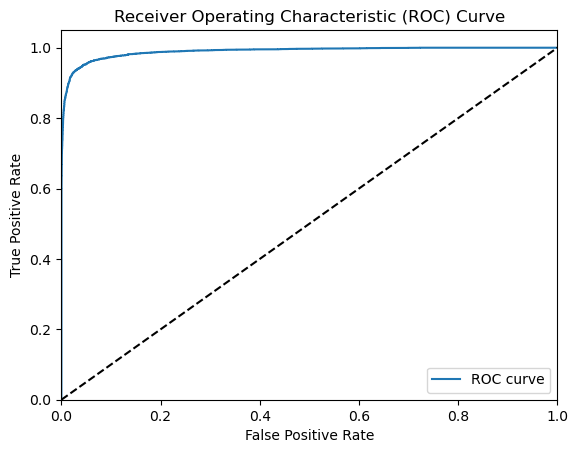

In [13]:
# Rebuild stacked ensemble with tuned models
tuned_base_models = [
    ('rf', rf_random.best_estimator_),
    # Add other tuned base models here
]

# Retrain and evaluate as in step 6
# ...

print("Final Model Performance:")
print(classification_report(y_test, final_predictions))
print("ROC AUC Score:", roc_auc_score(y_test, meta_model.predict_proba(test_meta_features)[:, 1]))

# Plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, meta_model.predict_proba(test_meta_features)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()